### Company XYZ started a subscription model in January, 2015. You get hired as a first data scientist at the end of August and, as a first task, you are asked to help executives understand how the subscription model is doing. Therefore, you decide to pull data from all the users who subscribed in January and see, for each month, how many of them unsubscribed. In particular, your boss is interested in:
#### (1) A model that predicts monthly retention rate for the different subscription price points

#### (2) Based on your model, for each price point, what percentage of users is still subscribed after at least 12 months?

#### (3) How do user country and source affect subscription retention rate? How would you use these findings to improve the company revenue?

### Load the package would be used

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 10)
pd.set_option("display.width", 350)

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({"figure.autolayout": True})
import seaborn as sns
sns.set(style = "white")
sns.set(style = "whitegrid", color_codes = True)

import statsmodels.api as sm

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

### Read in the data set

In [2]:
subscribe = pd.read_csv("../Datasets/subscription.csv")

### Look into dataset

In [3]:
print(subscribe.shape)
print(subscribe.head)
print(subscribe.info)
print(len(subscribe["user_id"]) == len(pd.unique(subscribe["user_id"])))
print(list(subscribe.columns))

(500000, 7)
<bound method NDFrame.head of         user_id subscription_signup_date  subscription_monthly_cost  country source  billing_cycles  is_active
0          1459            January, 2015                         29    Spain    ads               4          0
1         12474            January, 2015                         49   France    ads               5          0
2         12294            January, 2015                         49  Germany    ads               2          0
3          3878            January, 2015                         49    China    ads               1          0
4          9567            January, 2015                         49       UK    ads               5          0
...         ...                      ...                        ...      ...    ...             ...        ...
499995   496962            January, 2015                         29    Spain    ads               2          0
499996   480669            January, 2015                         29   

In [4]:
subscribe["subscription_signup_date"] = pd.to_datetime(subscribe["subscription_signup_date"])
print(subscribe.describe())
print(subscribe.groupby(["subscription_monthly_cost"]).size())
print(subscribe.groupby(["subscription_signup_date"]).size())
print(subscribe.groupby(["country"]).size())
print(subscribe.groupby(["source"]).size())
print(subscribe.groupby(["billing_cycles"]).size())
print(subscribe.groupby(["is_active"]).size())

             user_id  subscription_monthly_cost  billing_cycles      is_active
count  500000.000000              500000.000000   500000.000000  500000.000000
mean   250000.500000                  48.469620        2.384970       0.099998
std    144337.711635                  19.570745        2.254952       0.299998
min         1.000000                  29.000000        1.000000       0.000000
25%    125000.750000                  29.000000        1.000000       0.000000
50%    250000.500000                  49.000000        1.000000       0.000000
75%    375000.250000                  49.000000        3.000000       0.000000
max    500000.000000                  99.000000        8.000000       1.000000
subscription_monthly_cost
29    146362
49    300397
99     53241
dtype: int64
subscription_signup_date
2015-01-01    500000
dtype: int64
country
China      35938
France     51662
Germany    88944
India      48027
Italy      47459
Spain      44987
UK         91252
US         91731
dtype: i

### Visualization

#### Overall

In [5]:
count_overall = subscribe[["user_id", "subscription_monthly_cost"]].groupby("subscription_monthly_cost").count().reset_index().rename(columns = {"user_id": "total"})
count_overall

,subscription_monthly_cost,total
0,29,146362
1,49,300397
2,99,53241


In [6]:
retention_overall = subscribe[["user_id", "subscription_monthly_cost", "billing_cycles"]].groupby(["subscription_monthly_cost", "billing_cycles"]).count().groupby("subscription_monthly_cost").cumsum().reset_index().rename(columns = {"user_id": "count"})
retention_overall = retention_overall.append(pd.DataFrame([[29, 0, 0], [49, 0, 0], [99, 0, 0]], 
                                                            columns = list(["subscription_monthly_cost", "billing_cycles", "count"])))

retention_overall = retention_overall[retention_overall["billing_cycles"] != 8].sort_values(by = ["subscription_monthly_cost", "billing_cycles"])

retention_rate_overall = retention_overall.merge(count_overall, on = "subscription_monthly_cost", how = "left")
retention_rate_overall["rate"] = (retention_rate_overall["total"] - retention_rate_overall["count"])/retention_rate_overall["total"]
retention_rate_overall["cycles"] = retention_rate_overall["billing_cycles"] + 1
retention_rate_overall["subscription_monthly_cost"] = "price" + retention_rate_overall["subscription_monthly_cost"].astype(str)
retention_rate_overall

,subscription_monthly_cost,billing_cycles,count,total,rate,cycles
0,price29,0,0,146362,1.000000,1
1,price29,1,57441,146362,0.607542,2
2,price29,2,79259,146362,0.458473,3
3,price29,3,91296,146362,0.376232,4
4,price29,4,99083,146362,0.323028,5
5,price29,5,104588,146362,0.285416,6
6,price29,6,108724,146362,0.257157,7
7,price29,7,111835,146362,0.235901,8
8,price49,0,0,300397,1.000000,1
9,price49,1,185145,300397,0.383666,2


Text(0, 0.5, 'Retention Rate')

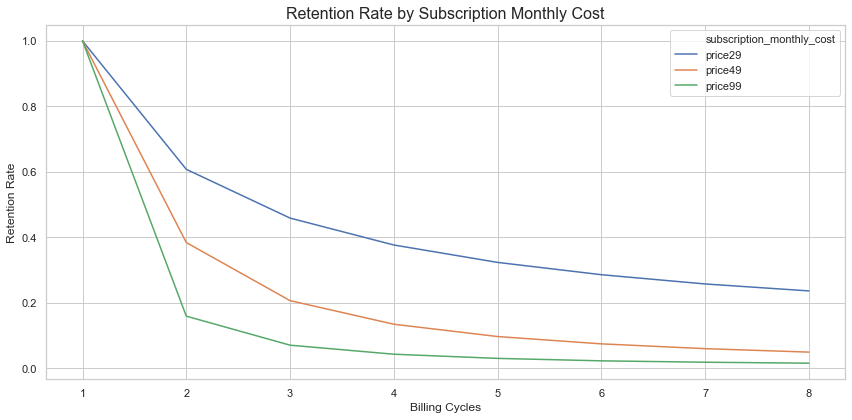

In [7]:
plt.figure(figsize = [12, 6])
sns.lineplot(x = "cycles", y = "rate", hue = "subscription_monthly_cost", data = retention_rate_overall)
plt.title("Retention Rate by Subscription Monthly Cost", fontsize = 16)
plt.xlabel("Billing Cycles", fontsize = 12)
plt.ylabel("Retention Rate", fontsize = 12)

#### Stratified by country

In [8]:
count_by_country = subscribe[["user_id", "subscription_monthly_cost", "country"]].groupby(["subscription_monthly_cost", "country"]).count().reset_index().rename(columns = {"user_id": "total"})
count_by_country

,subscription_monthly_cost,country,total
0,29,China,16741
1,29,France,14249
2,29,Germany,21794
3,29,India,16920
4,29,Italy,13336
5,29,Spain,12725
6,29,UK,25181
7,29,US,25416
8,49,China,18541
9,49,France,31074


In [9]:
retention_by_country = subscribe[["user_id", "subscription_monthly_cost", "billing_cycles", "country"]].groupby(["subscription_monthly_cost", "billing_cycles", "country"]).count().groupby(["subscription_monthly_cost", "country"]).cumsum().reset_index().rename(columns = {"user_id": "count"})
retention_by_country = retention_by_country.append(pd.DataFrame([[29, 0, "China", 0], [49, 0, "China", 0], [99, 0, "China", 0],
                                                                 [29, 0, "France", 0], [49, 0, "France", 0], [99, 0, "France", 0],
                                                                 [29, 0, "Germany", 0], [49, 0, "Germany", 0], [99, 0, "Germany", 0],
                                                                 [29, 0, "India", 0], [49, 0, "India", 0], [99, 0, "India", 0],
                                                                 [29, 0, "Italy", 0], [49, 0, "Italy", 0], [99, 0, "Italy", 0],
                                                                 [29, 0, "Spain", 0], [49, 0, "Spain", 0], [99, 0, "Spain", 0],
                                                                 [29, 0, "UK", 0], [49, 0, "UK", 0], [99, 0, "UK", 0],
                                                                 [29, 0, "US", 0], [49, 0, "US", 0], [99, 0, "US", 0]],
                                                                columns = list(["subscription_monthly_cost", "billing_cycles", "country", "count"])))
retention_by_country = retention_by_country[retention_by_country["billing_cycles"] != 8].sort_values(by = ["subscription_monthly_cost", "country", "billing_cycles"])
retention_rate_by_country = retention_by_country.merge(count_by_country, on = ["subscription_monthly_cost", "country"], how = "left")
retention_rate_by_country["rate"] = (retention_rate_by_country["total"] - retention_rate_by_country["count"])/retention_rate_by_country["total"]
retention_rate_by_country["cycles"] = retention_rate_by_country["billing_cycles"] + 1
retention_rate_by_country["subscription_monthly_cost"] = "price" + retention_rate_by_country["subscription_monthly_cost"].astype(str)
retention_rate_by_country

,subscription_monthly_cost,billing_cycles,country,count,total,rate,cycles
0,price29,0,China,0,16741,1.000000,1
1,price29,1,China,3464,16741,0.793083,2
2,price29,2,China,4396,16741,0.737411,3
3,price29,3,China,4967,16741,0.703303,4
4,price29,4,China,5429,16741,0.675706,5
...,...,...,...,...,...,...,...
187,price99,3,US,10336,10930,0.054346,4
188,price99,4,US,10522,10930,0.037328,5
189,price99,5,US,10625,10930,0.027905,6
190,price99,6,US,10676,10930,0.023239,7


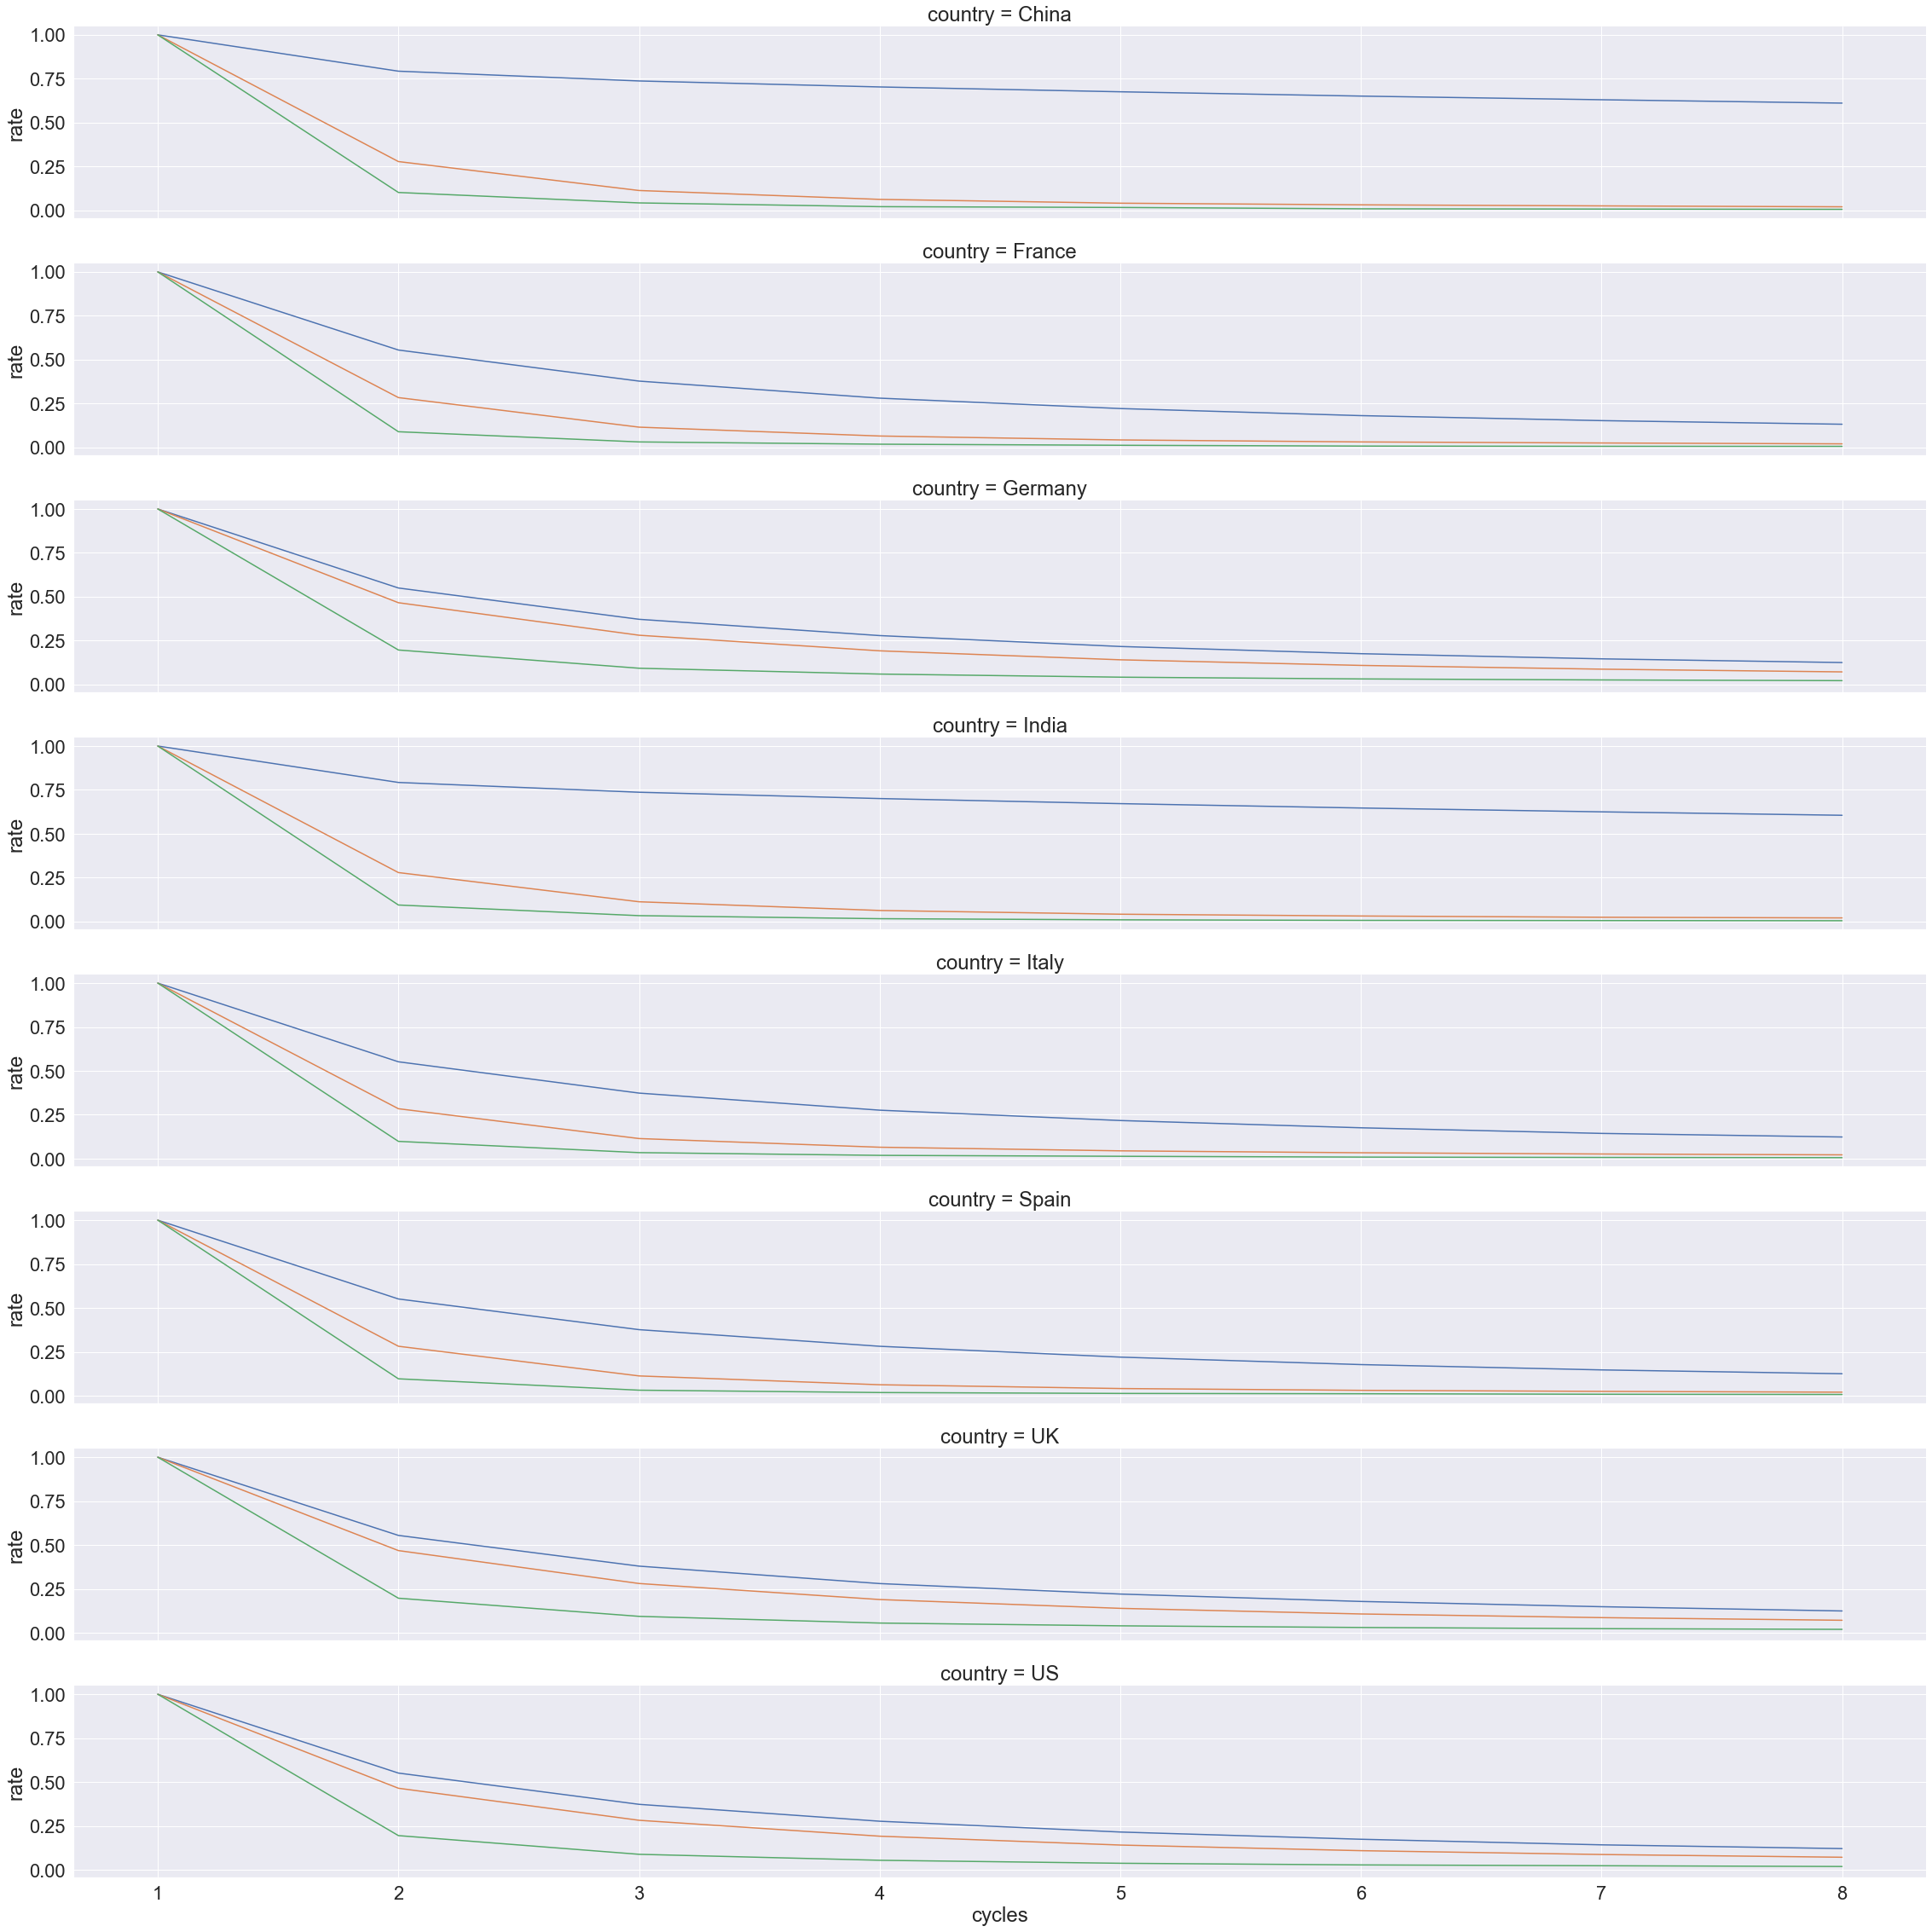

In [10]:
sns.set(font_scale = 2)
by_country = sns.FacetGrid(retention_rate_by_country, row = "country", hue = "subscription_monthly_cost",
                          height = 4, aspect = 8).map(plt.plot, "cycles", "rate")

### Stratified by source

In [11]:
count_by_source = subscribe[["user_id", "subscription_monthly_cost", "source"]].groupby(["subscription_monthly_cost", "source"]).count().reset_index().rename(columns = {"user_id": "total"})
count_by_source

,subscription_monthly_cost,source,total
0,29,ads,121246
1,29,friend_referral,7097
2,29,seo,18019
3,49,ads,249177
4,49,friend_referral,14589
5,49,seo,36631
6,99,ads,44046
7,99,friend_referral,2742
8,99,seo,6453


In [12]:
retention_by_source = subscribe[["user_id", "subscription_monthly_cost", "billing_cycles", "source"]].groupby(["subscription_monthly_cost", "billing_cycles", "source"]).count().groupby(["subscription_monthly_cost", "source"]).cumsum().reset_index().rename(columns = {"user_id": "count"})
retention_by_source = retention_by_source.append(pd.DataFrame([[29, 0, "ads", 0], [49, 0, "ads", 0], [99, 0, "ads", 0],
                                                               [29, 0, "friend_referral", 0], [49, 0, "friend_referral", 0], [99, 0, "friend_referral", 0],
                                                               [29, 0, "seo", 0], [49, 0, "seo", 0], [99, 0, "seo", 0]],
                                                                columns = list(["subscription_monthly_cost", "billing_cycles", "source", "count"])))
retention_by_source = retention_by_source[retention_by_source["billing_cycles"] != 8].sort_values(by = ["subscription_monthly_cost", "source", "billing_cycles"])
retention_rate_by_source = retention_by_source.merge(count_by_source, on = ["subscription_monthly_cost", "source"], how = "left")
retention_rate_by_source["rate"] = (retention_rate_by_source["total"] - retention_rate_by_source["count"])/retention_rate_by_source["total"]
retention_rate_by_source["cycles"] = retention_rate_by_source["billing_cycles"] + 1
retention_rate_by_source["subscription_monthly_cost"] = "price" + retention_rate_by_source["subscription_monthly_cost"].astype(str)
retention_rate_by_source

,subscription_monthly_cost,billing_cycles,source,count,total,rate,cycles
0,price29,0,ads,0,121246,1.000000,1
1,price29,1,ads,50606,121246,0.582617,2
2,price29,2,ads,70217,121246,0.420872,3
3,price29,3,ads,80800,121246,0.333586,4
4,price29,4,ads,87535,121246,0.278038,5
...,...,...,...,...,...,...,...
67,price99,3,seo,5817,6453,0.098559,4
68,price99,4,seo,5973,6453,0.074384,5
69,price99,5,seo,6092,6453,0.055943,6
70,price99,6,seo,6155,6453,0.046180,7


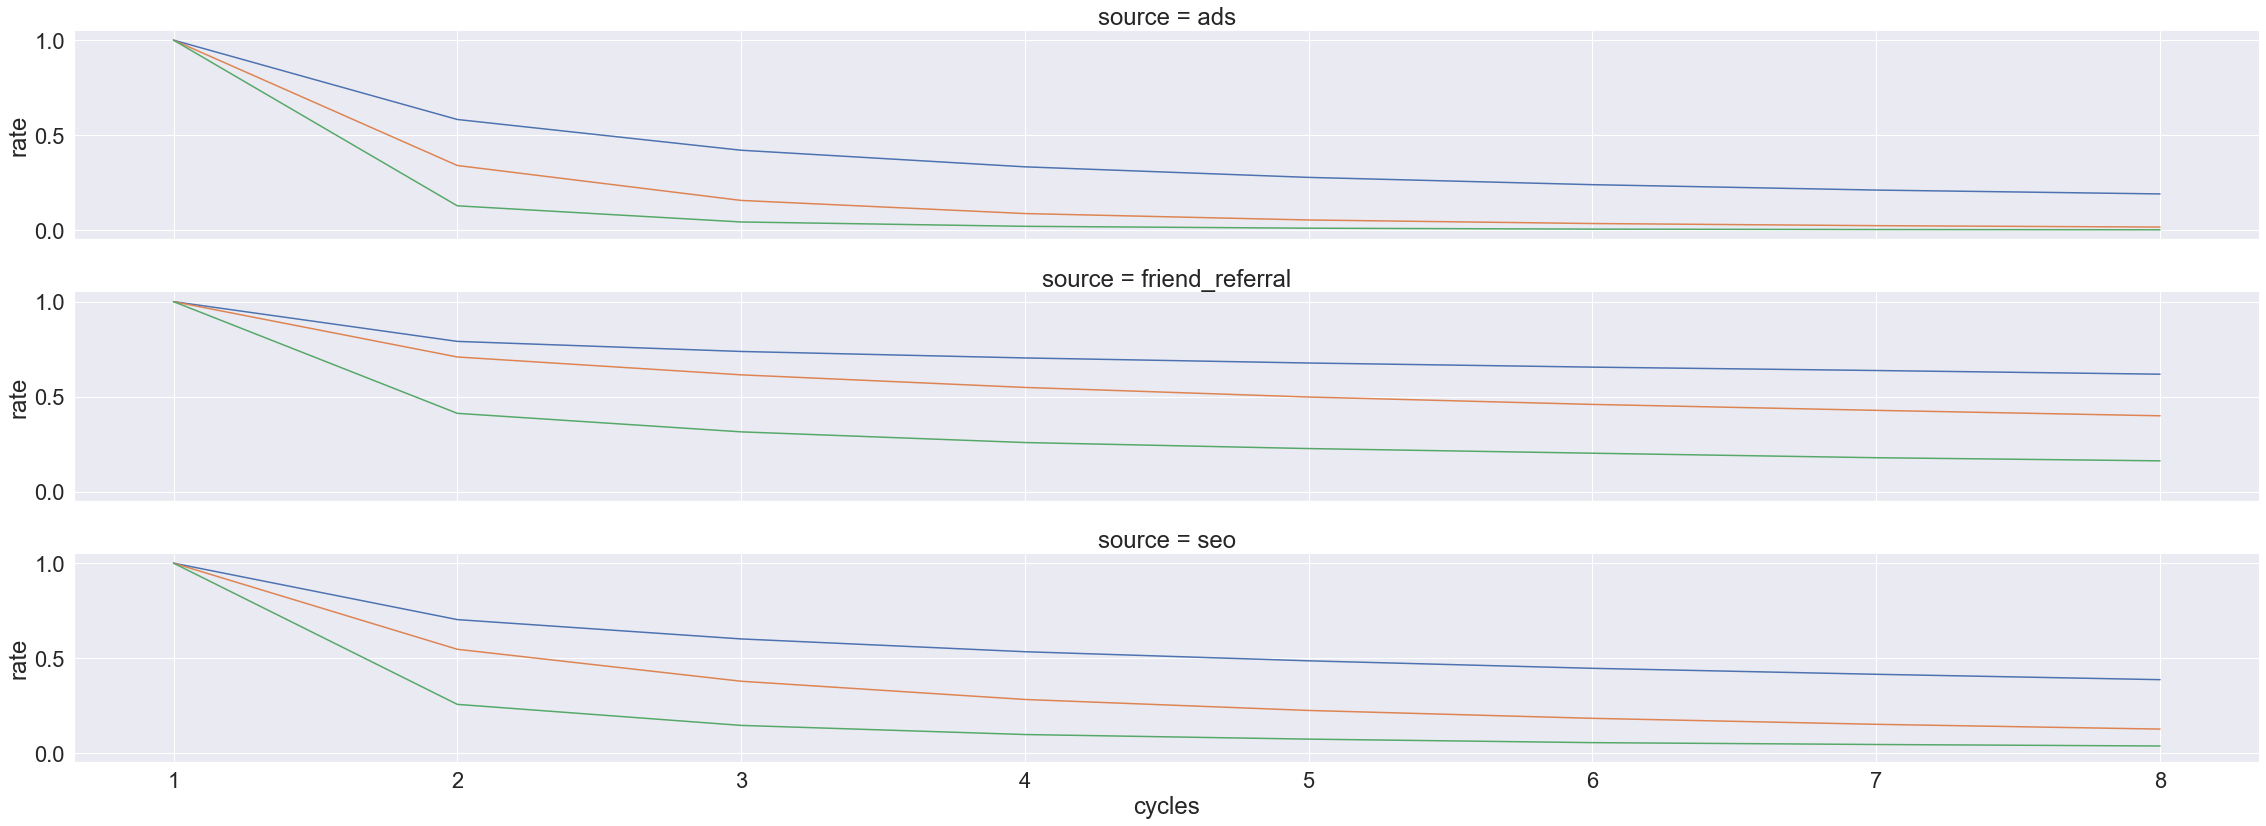

In [13]:
sns.set(font_scale = 2)
by_source = sns.FacetGrid(retention_rate_by_source, row = "source", hue = "subscription_monthly_cost",
                          height = 4, aspect = 8).map(plt.plot, "cycles", "rate")

#### (1) A model that predicts monthly retention rate for the different subscription price points

In [14]:
retention_rate_overall["log_rate"] = np.log(retention_rate_overall["rate"])
retention_rate_overall["log_cycles"] = np.log(retention_rate_overall["cycles"])
retention_rate_overall["const"] = 1.0
retention_rate_overall

,subscription_monthly_cost,billing_cycles,count,total,rate,cycles,log_rate,log_cycles,const
0,price29,0,0,146362,1.000000,1,0.000000,0.000000,1.0
1,price29,1,57441,146362,0.607542,2,-0.498335,0.693147,1.0
2,price29,2,79259,146362,0.458473,3,-0.779854,1.098612,1.0
3,price29,3,91296,146362,0.376232,4,-0.977551,1.386294,1.0
4,price29,4,99083,146362,0.323028,5,-1.130017,1.609438,1.0
5,price29,5,104588,146362,0.285416,6,-1.253809,1.791759,1.0
6,price29,6,108724,146362,0.257157,7,-1.358069,1.945910,1.0
7,price29,7,111835,146362,0.235901,8,-1.444341,2.079442,1.0
8,price49,0,0,300397,1.000000,1,0.000000,0.000000,1.0
9,price49,1,185145,300397,0.383666,2,-0.957984,0.693147,1.0


In [15]:
const = np.zeros(12) + 1
cycles = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
log_cycles = np.log(cycles)
yr_dat = pd.DataFrame({"const": const, "cycles": cycles, "log_cycles": log_cycles},
                      columns = ["const", "cycles", "log_cycles"])

In [16]:
def ols_res(dat, new_dat, xcols, ycol):
    lin_reg = sm.OLS(dat[ycol], dat[xcols]).fit()
    rate = np.exp(lin_reg.predict(yr_dat[["const", "cycles", "log_cycles"]])[len(yr_dat) - 1])
    return rate

#### (2) Based on your model, for each price point, what percentage of users is still subscribed after at least 12 months?

In [17]:
linear_regression_by_price = retention_rate_overall.groupby("subscription_monthly_cost").apply(ols_res, new_dat = yr_dat, xcols = ["const", "cycles", "log_cycles"], ycol = "log_rate")
linear_regression_by_price

subscription_monthly_cost
price29    0.182635
price49    0.026138
price99    0.013590
dtype: float64

#### (3) How do user country and source affect subscription retention rate? How would you use these findings to improve the company revenue?

See visualization part.